# interpolating between transport on SSH contours

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cftime
import glob
import dask
import os
import datetime
import matplotlib.colors as col
import dask.array as dsa
from cosima_cookbook import distributed as ccd
import cartopy.crs as ccrs
import cmocean as cm
from scipy.ndimage.filters import uniform_filter1d



import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46569,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:42547,Total threads: 2
Dashboard: /proxy/41323/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:38025,


In [9]:
vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/DP_vh_eddy_interp_upwellingarm_constant.nc').vh_eddy_interp  
vh_eddy#.plot()

<xarray.DataArray 'vh_eddy_interp' (y_ocean: 904, x_ocean: 601)>
[543304 values with dtype=float64]
Coordinates:
  * x_ocean  (x_ocean) float64 -70.0 -69.95 -69.9 -69.85 ... -40.1 -40.05 -40.0
  * y_ocean  (y_ocean) float64 -64.99 -64.97 -64.95 ... -38.09 -38.05 -38.01

Load contour picture with MKE

In [3]:
EKE = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/EKE_10yr.nc').EKE
MKE = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/MKE_10yr.nc').MKE
Reynolds = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/Reynolds_10yr_fulldepth.nc').Reynolds
Form_stress = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/Form_stress_10yr_fulldepth.nc').Form_stress

In [4]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [5]:
# This example script just calculates transports for a single year. 
# You'll need to run it multiple times (or set up loop over years)

year = '2170'
expt = '01deg_jra55v13_ryf9091'

start_time= year + '-01-01'
end_time= year + '-12-31'

# reference density value:
rho_0 = 1035.0
# Note: change this range, so it matches the size of your contour arrays:

## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)
#-0.1,2,3,4,5#
lat_range = slice(-60,-34.99)
lat_range_big = slice(-60.05,-34.90)
#-0.6,7#
lat_range = slice(-60,-39.98)
lat_range_big = slice(-60.05,-39.90)
#-0.8,-0.9,-1.0#
lat_range = slice(-62.91,-45)
lat_range_big = slice(-62.96,-44.90)
#-1.1,1.2#
lat_range = slice(-64.99,-47)
lat_range_big = slice(-65.02,-46.93)
#-1.3,1.4,-1.5#
lat_range = slice(-70,-47)
lat_range_big = slice(-70.05,-46.93)
# Select contour depth



In [6]:
from collections import OrderedDict


In [7]:
hotspot_dict = OrderedDict([
    ('PAR',  {'lon_slice':slice(-160,-130),'lat_slice':slice(-60,-50)}),
    ('KP',  {'lon_slice':slice(-280,-250),'lat_slice':slice(-60,-40)}),
    ('SWIR',  {'lon_slice':slice(10,50),'lat_slice':slice(-55,-45)}),
    ('DP',  {'lon_slice':slice(-70,-30),'lat_slice':slice(-60,-40)}),
    ('MR',  {'lon_slice':slice(-210,-170),'lat_slice':slice(-60,-45)}),

])

CPU times: user 453 ms, sys: 104 ms, total: 557 ms
Wall time: 609 ms


Text(0.5, 1.0, 'SWIR Smoothed Eddy Transport across contours, sigma_1 = 1032.4, averaged over 10 years')

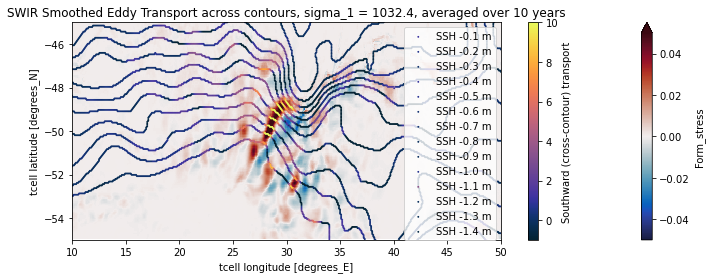

In [8]:
%%time
ekey = 'SWIR'
year = '2170'
fig = plt.figure(figsize = (12,4))
lat_slice = hotspot_dict[ekey]['lat_slice']
lon_slice = hotspot_dict[ekey]['lon_slice']
isopycnal_bins_sigma1 = 1000+ np.array([1,28,29,30,31,31.5,31.9,32,32.1,32.2,32.25,32.3,
                                        32.35,32.4,32.42,32.44,32.46,32.48,32.50,32.51,
                                        32.52,32.53,32.54,32.55,32.56,32.58,32.6,32.8,33,34,45])
rho = 1032.4
Form_stress.sel(isopycnal_bins = rho, method = 'nearest').sel(yt_ocean = lat_slice,xt_ocean = lon_slice).plot(cmap = cm.cm.balance, vmax = 0.05, vmin = -0.05)

for j in np.arange(14):
    j_contour = np.array(['A','B','C','D','E','F','G','H','I','J','K','L','M','N'])[j]
    color = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14'][j]
    SSH = [-0.1,-0.2,-0.3,-0.4,-0.5,-0.6,-0.7,-0.8,-0.9,-1.0,-1.1,-1.2,-1.3,-1.4][j]
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lat_along_contour
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon.nc').lon_along_contour
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').top_rho1_max_contour
    bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').bottom_rho1_min_contour
    segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length.nc').segment_length
    vh_eddy= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)

    N=10

    eddy_notcumsum = vh_eddy.sel(isopycnal_bins=slice(1030,1032.5)).sum('isopycnal_bins').fillna(0)
    y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length.values
#     dx, dy = find_arrow_dxn(lon_along_contour,lat_along_contour)
#     for i in np.arange(10,len(lon_along_contour),25):

#         plt.arrow(lon_along_contour[i],lat_along_contour[i],y[i]/400*dx[i],y[i]/400*dy[i],head_width = 0.2, head_length = 0.2,length_includes_head=True, color = color)#, head_length = 0.1,length_includes_head=True)

    sc = plt.scatter(lon_along_contour,lat_along_contour, s=0.7, label = 'SSH '+str(SSH)+' m', c = -y , cmap = cm.cm.thermal, vmin = -1, vmax = 10)

plt.legend(loc = 'upper right')
cbar = fig.colorbar(sc)
cbar.set_label('Southward (cross-contour) transport', rotation=90)
plt.ylim(-55,-45)
plt.xlim(10,50)

plt.title('SWIR Smoothed Eddy Transport across contours, sigma_1 = '+str(rho)+', averaged over 10 years')

### Want to fill in the gaps between contours, so relationship with form stress conversion can be better observed

In [9]:
expt = '01deg_jra55v13_ryf9091'

## FULL SO ##
lat_range = slice(-70,-34.99)
lat_range_big =  slice(-70.05,-34.90)

yt_ocean = cc.querying.getvar(expt,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(expt,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)

xt_ocean = cc.querying.getvar(expt,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(expt,'xu_ocean',session,n=1)




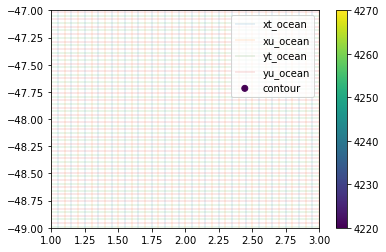

In [10]:
plt.vlines(xt_ocean.values, -50,-45, linewidth = 0.2, label = 'xt_ocean')
plt.vlines(xu_ocean.values, -50,-45, linewidth = 0.2, label = 'xu_ocean', color = 'C1')
plt.hlines(yt_ocean.values, 1,3, linewidth = 0.2, label = 'yt_ocean', color = 'C2')
plt.hlines(yu_ocean.values, 1,3, linewidth = 0.2, label = 'yu_ocean', color = 'C3')




plt.scatter(lon_along_contour, lat_along_contour, marker = 'o', label = 'contour', c = lon_along_contour.contour_index, vmin = 4220,vmax = 4270)
plt.colorbar()
plt.xlim(1,3)
plt.ylim(-49,-47)
plt.legend()

#### create an array of t and u grids together since the contours have values on both.

In [11]:
xt_ocean = xt_ocean.rename({'xt_ocean':'x_ocean'})
xu_ocean = xu_ocean.rename({'xu_ocean':'x_ocean'})
yt_ocean = yt_ocean.rename({'yt_ocean':'y_ocean'})
yu_ocean = yu_ocean.rename({'yu_ocean':'y_ocean'})






In [12]:
x = xr.merge([xt_ocean,xu_ocean])
y = xr.merge([yt_ocean, yu_ocean])
#x = np.arange(-279.95,80.01,0.05)


In [13]:
transport = xr.DataArray(np.zeros((len(x.x_ocean),len(y.y_ocean))), 
                                               coords = [np.round(x.x_ocean.values,2),np.round(y.y_ocean.values,2)], 
                                               dims = ['x_ocean','y_ocean'], 
                                               name = 'transport')
SSH_contours = xr.DataArray(np.zeros((len(x.x_ocean),len(y.y_ocean))), 
                                               coords = [np.round(x.x_ocean.values,2),np.round(y.y_ocean.values,2)], 
                                               dims = ['x_ocean','y_ocean'], 
                                               name = 'SSH_contours')



In [14]:
contour_dict = OrderedDict([
    ('A',  {'SSH':-0.1,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.1m_SSH.npz','shifted':False}),
    ('B',  {'SSH':-0.2,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.2m_SSH.npz','shifted':False}),
    ('C',  {'SSH':-0.3,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.3m_SSH.npz','shifted':False}),
    ('D',  {'SSH':-0.4,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.4m_SSH.npz','shifted':False}),
    ('E',  {'SSH':-0.5,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.5m_SSH.npz','shifted':False}),
    ('F',  {'SSH':-0.6, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.6m_SSH.npz','shifted':False}),
    ('G',  {'SSH':-0.7, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.7m_SSH.npz','shifted':False}),
    ('H',  {'SSH':-0.8, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.8m_SSH.npz','shifted':False}),
    ('I',  {'SSH':-0.9, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.9m_SSH.npz','shifted':False}),
    ('J',  {'SSH':-1.0, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.0m_SSH.npz','shifted':False}),
    ('K',  {'SSH':-1.1, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.1m_SSH.npz','shifted':False}),
    ('L',  {'SSH':-1.2, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.2m_SSH.npz','shifted':False}),
    ('M',  {'SSH':-1.3, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.3m_SSH.npz','shifted':False}),
    ('N',  {'SSH':-1.4, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.4m_SSH.npz','shifted':False}),
    ('O',  {'SSH':-1.5, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.5m_SSH.npz','shifted':True}),
    ('P',  {'SSH':-0.15,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.15m_SSH.npz','shifted':False}),
    ('Q',  {'SSH':-0.25,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.25m_SSH.npz','shifted':False}),
    ('R',  {'SSH':-0.35,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.35m_SSH.npz','shifted':False}),
    ('S',  {'SSH':-0.45,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.45m_SSH.npz','shifted':False}),
    ('T',  {'SSH':-0.55,'lat_range':slice(-60,-34.99),'lat_range_big':slice(-60.05,-34.90),'slope_path':'SO_slope_contour_-0.55m_SSH.npz','shifted':False}),
    ('U',  {'SSH':-0.65, 'lat_range':slice(-60,-39.98),'lat_range_big':slice(-60.05,-39.90),'slope_path':'SO_slope_contour_-0.65m_SSH.npz','shifted':False}),
    ('V',  {'SSH':-0.75, 'lat_range':slice(-61,-39.98),'lat_range_big':slice(-61.05,-39.90),'slope_path':'SO_slope_contour_-0.75m_SSH.npz','shifted':False}),
    ('W',  {'SSH':-0.85,'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.85m_SSH.npz','shifted':False}),
    ('X',  {'SSH':-0.95, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-0.95m_SSH.npz','shifted':False}),
    ('Y',  {'SSH':-1.05, 'lat_range':slice(-62.91,-45), 'lat_range_big':slice(-62.96,-44.90),'slope_path':'SO_slope_contour_-1.05m_SSH.npz','shifted':False}),
    ('Z',  {'SSH':-1.15, 'lat_range':slice(-64.99,-47), 'lat_range_big':slice(-65.02,-46.93),'slope_path':'SO_slope_contour_-1.15m_SSH.npz','shifted':False}),
    ('Z1',  {'SSH':-1.25, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.25m_SSH.npz','shifted':False}),
    ('Z2',  {'SSH':-1.35, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.35m_SSH.npz','shifted':False}),
    ('Z3',  {'SSH':-1.45, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.45m_SSH.npz','shifted':True}),
    ('Z4',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_A.npz','shifted':True}),
    ('Z5',  {'SSH':-1.55, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.55m_SSH_B.npz','shifted':True}),
    ('Z6',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_A.npz','shifted':True}),
    ('Z7',  {'SSH':-1.6, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.6m_SSH_B.npz','shifted':True}),
    ('Z8',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_A.npz','shifted':True}),
    ('Z9',  {'SSH':-1.65, 'lat_range':slice(-70,-47), 'lat_range_big':slice(-70.05,-46.93),'slope_path':'SO_slope_contour_-1.65m_SSH_B.npz','shifted':True}),
])

### Fill in transport data on known coordinates

In [15]:
for j in np.arange(35):
    j_contour = np.array(['A','P','B','Q','C','R','D','S','E','T','F','U','G','V','H','W','I','X','J','Y',
                              'K','Z','L','Z1','M','Z2','N','Z3','O','Z4','Z5','Z6','Z7','Z8','Z9'])[j]
    SSH = contour_dict[j_contour]['SSH']
    if contour_dict[j_contour]['shifted']==True:
        suffix = '_shiftedback'
    else:
        suffix = ''
    vh_eddy = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/vh_eddy_SO_'+j_contour+suffix+'.nc').vh_eddy
    lat_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lat_along_contour.values
    lon_along_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_latlon'+suffix+'.nc').lon_along_contour.values
    isopycnal_bin_contour = vh_eddy*0+vh_eddy.isopycnal_bins
    #top_rho1_max_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').top_rho1_max_contour
    #bottom_rho1_min_contour = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'bottom_min_top_max_rho1_contour.nc').bottom_rho1_min_contour
    segment_length = xr.open_dataset('/g/data/x77/cy8964/Post_Process/New_SO/SO_'+j_contour+'_segment_length.nc').segment_length
    #vh_eddy= vh_eddy.where(isopycnal_bin_contour > top_rho1_max_contour).where(isopycnal_bin_contour <bottom_rho1_min_contour).fillna(0)

    N=10

    eddy_notcumsum = vh_eddy.sel(isopycnal_bins=slice(1032.2,1032.5)).sum('isopycnal_bins').fillna(0)
    y = uniform_filter1d(eddy_notcumsum, size=N)/segment_length.values

    for i in range(len(lat_along_contour)):
        transport.loc[dict(x_ocean=np.round(lon_along_contour[i],2), y_ocean = np.round(lat_along_contour[i],2))] = y[i]
        SSH_contours.loc[dict(x_ocean=np.round(lon_along_contour[i],2), y_ocean = np.round(lat_along_contour[i],2))] = SSH
#     transport.loc[dict(x_ocean=lon_along_contour, y_ocean = lat_along_contour)] = y
#     SSH_contours.loc[dict(x_ocean=lon_along_contour, y_ocean = lat_along_contour)] = SSH


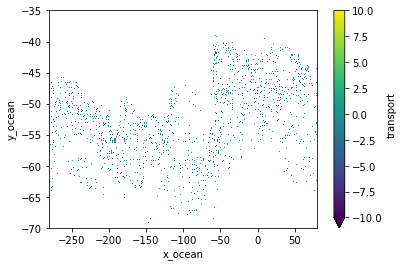

In [16]:
transport.where(transport !=0).plot(vmax = 10, vmin = -10, x = 'x_ocean')

# For each point, find points along adjacent contours that are closest to the points, and weight transport according to the distances

In [17]:
hotspot_dict = OrderedDict([
('PAR',  {'lower_lon':-160,'upper_lon':-110}),
('SWIR',  {'lower_lon':10,'upper_lon':50}),
('DP',  {'lower_lon':-70,'upper_lon':0}),
('MR',  {'lower_lon':-220,'upper_lon':-170}),
('KP1',  {'lower_lon':60,'upper_lon':80}),
('KP2',{'lower_lon':-280,'upper_lon':-260})])


First, select hotspot region. This is for Kerguelen Plateau, which is on the edge, so we roll into different coordinates (this step not needed for other hotspots)

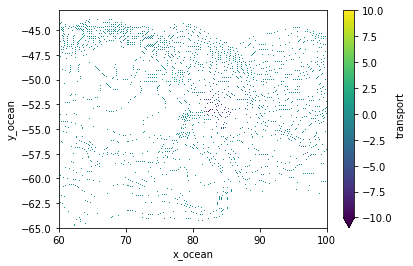

In [18]:
transport_mini = transport.roll(x_ocean = 1600)
transport_mini['x_ocean'] = np.arange(0.05,360.01,0.05)
transport_mini = transport_mini.sel(x_ocean = slice(60,100),y_ocean = slice(-65,-43))
SSH_contour_mini = SSH_contours.roll(x_ocean = 1600)
SSH_contour_mini['x_ocean'] = np.arange(0.05,360.01,0.05)
SSH_contour_mini = SSH_contour_mini.sel(x_ocean = slice(60,100),y_ocean = slice(-65,-43))
transport_mini.where(transport_mini !=0).plot(vmax = 10, vmin = -10, x = 'x_ocean')


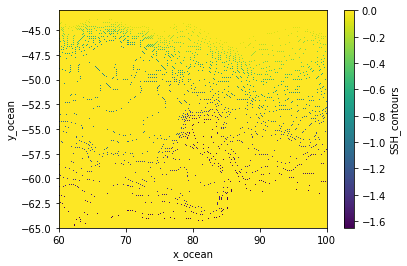

In [19]:
SSH_contour_mini.plot(x = 'x_ocean')

Now fill in the gaps between points on lines, since the 0.05 degree grid has gaps

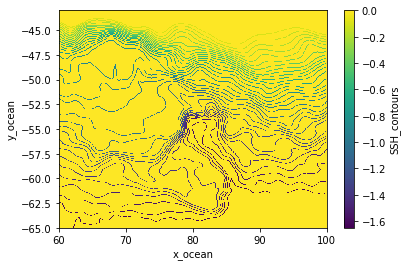

In [20]:
SSH_filter = SSH_contour_mini.copy()
for i in range(len(SSH_filter.x_ocean)-1):
    for j in range(len(SSH_filter.y_ocean)-1):
        if SSH_filter[i,j]==0:
            if SSH_filter[i+1,j]!=0:
                SSH_filter[i,j]=SSH_filter[i+1,j]
            elif SSH_filter[i,j+1]!=0:
                SSH_filter[i,j]=SSH_filter[i,j+1]
            elif SSH_filter[i+1,j+1]!=0:
                SSH_filter[i,j]=SSH_filter[i+1,j+1]
        if j==len(SSH_filter.y_ocean)-1:
            if SSH_filter[i-1,j]!=0:
                SSH_filter[i,j]=SSH_filter[i-1,j]
            elif SSH_filter[i,j-1]!=0:
                SSH_filter[i,j]=SSH_filter[i,j-1]
            elif SSH_filter[i-1,j-1]!=0:
                SSH_filter[i,j]=SSH_filter[i-1,j-1]


            
SSH_filter.plot(x = 'x_ocean')

Find where the top and bottom contours are so that we don't interpolate outside of the SSH contour regions

In [21]:
#contour_mask = contour_mask[1:-2][1:-2]
contour_mask_numbered = SSH_filter.where(SSH_filter == -0.1).fillna(0).transpose('y_ocean','x_ocean')

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above1 = np.copy(contour_mask_numbered)

contour_masked_above1[-1,0] = -100
contour_masked_above[-1,0] = -100
contour_masked_above[-1,-1] = -100

# from top left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
#             if contour_masked_above[jj-1,ii+1] == 0:
#                 contour_masked_above[jj-1,ii+1] = -100
#from top right:
# for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
#     for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
#         if contour_masked_above[jj,ii] == -100:
#             if contour_masked_above[jj-1,ii] == 0:
#                 contour_masked_above[jj-1,ii] = -100
#             if contour_masked_above[jj,ii-1] == 0:
#                 contour_masked_above[jj,ii-1] = -100
#             if contour_masked_above[jj-1,ii-1] == 0:
#                 contour_masked_above[jj-1,ii-1] = -100
# # from bottom right:
for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
# #             if contour_masked_above[jj+1,ii-1] == 0:
# #                 contour_masked_above[jj+1,ii-1] = -100
# #from bottom left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
                print('helo')
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
# #             if contour_masked_above[jj+1,ii+1] == 0:
# #                 contour_masked_above[jj+1,ii+1] = -100
top_mask = SSH_filter*0+ np.transpose(contour_masked_above)

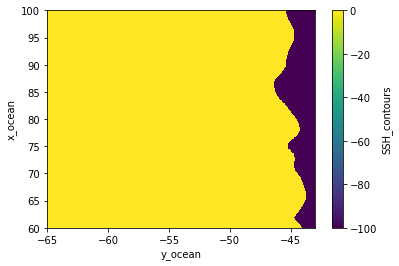

In [22]:
top_mask.plot()

In [23]:
#contour_mask = contour_mask[1:-2][1:-2]
contour_mask_numbered = SSH_filter.where(SSH_filter == -1.65).fillna(0).transpose('y_ocean','x_ocean')

# fill in points to north of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above1 = np.copy(contour_mask_numbered)

contour_masked_above1[-1,0] = -100
contour_masked_above[-1,0] = -100

# from top left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj-1,ii] == 0:
                contour_masked_above[jj-1,ii] = -100
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
#             if contour_masked_above[jj-1,ii+1] == 0:
#                 contour_masked_above[jj-1,ii+1] = -100
# from top right:
# for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
#     for jj in range(len(contour_mask_numbered.y_ocean))[::-1][:-1]:
#         if contour_masked_above[jj,ii] == -100:
#             if contour_masked_above[jj-1,ii] == 0:
#                 contour_masked_above[jj-1,ii] = -100
#             if contour_masked_above[jj,ii-1] == 0:
#                 contour_masked_above[jj,ii-1] = -100
#             if contour_masked_above[jj-1,ii-1] == 0:
#                 contour_masked_above[jj-1,ii-1] = -100
# # from bottom right:
for ii in range(len(contour_mask_numbered.x_ocean))[::-1][:-1]:
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
            if contour_masked_above[jj,ii-1] == 0:
                contour_masked_above[jj,ii-1] = -100
# #             if contour_masked_above[jj+1,ii-1] == 0:
# #                 contour_masked_above[jj+1,ii-1] = -100
# #from bottom left:
for ii in range(len(contour_mask_numbered.x_ocean)-1):
    for jj in range(len(contour_mask_numbered.y_ocean)-1):
        if contour_masked_above[jj,ii] == -100:
            if contour_masked_above[jj+1,ii] == 0:
                contour_masked_above[jj+1,ii] = -100
                print('helo')
            if contour_masked_above[jj,ii+1] == 0:
                contour_masked_above[jj,ii+1] = -100
# #             if contour_masked_above[jj+1,ii+1] == 0:
# #                 contour_masked_above[jj+1,ii+1] = -100
bottom_mask =  SSH_filter*0+ np.transpose(contour_masked_above)

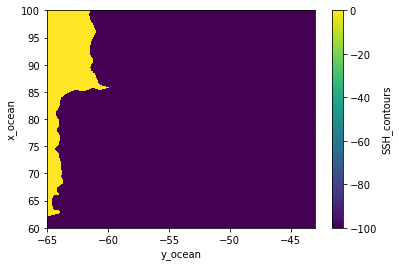

In [24]:
bottom_mask.plot()

In [25]:
%%time
SSH_contour_mini_nan = SSH_contour_mini.where(SSH_contour_mini !=0)
xs = SSH_contour_mini_nan*0+SSH_contour_mini_nan.x_ocean
ys = SSH_contour_mini_nan*0+SSH_contour_mini_nan.y_ocean

xs2 = SSH_contour_mini*0+SSH_contour_mini.x_ocean
ys2 = SSH_contour_mini*0+SSH_contour_mini.y_ocean


transport_new = transport_mini.copy()
transport_new = transport_new.where(top_mask !=-100).where(bottom_mask !=0)

CPU times: user 24.7 ms, sys: 99 µs, total: 24.8 ms
Wall time: 21.1 ms


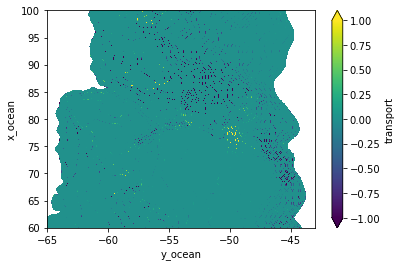

In [26]:
transport_new.plot(vmin = -1, vmax = 1)

We have masked out data outside of the SSH contours. Now, interpolate with a long (slow) loop

In [27]:
%%time


for i in range(len(transport_new.x_ocean)-1):
    print(i)
    for j in range(len(transport_new.y_ocean)-1):
        if transport_new[i,j]==0:
            dist_ij = (xs-transport_new.x_ocean[i])**2+(ys-transport_new.y_ocean[j])**2
            dist_ij_1_x = dist_ij.min('y_ocean').argmin('x_ocean')
            dist_ij_1_y = dist_ij.min('x_ocean').argmin('y_ocean')
            dist_ij_1 = dist_ij.min('x_ocean').min('y_ocean')
            dist_ij_SSH = SSH_contour_mini_nan.isel(x_ocean = dist_ij_1_x, y_ocean = dist_ij_1_y)
            dist_ij_2_x = dist_ij.where(SSH_contour_mini_nan != dist_ij_SSH).min('y_ocean').argmin('x_ocean')
            dist_ij_2_y = dist_ij.where(SSH_contour_mini_nan != dist_ij_SSH).min('x_ocean').argmin('y_ocean')
            dist_ij_2 = dist_ij.where(SSH_contour_mini_nan != dist_ij_SSH).min('y_ocean').min('x_ocean')
            #dist_ij_SSH = SSH_contour_mini_nan.isel(x_ocean = dist_ij_2_x, y_ocean = dist_ij_2_y)
            ratio_1 = 1-dist_ij_1.values/(dist_ij_1.values+dist_ij_2.values)
            transport_new[i,j] = ratio_1*transport_mini.isel(x_ocean = dist_ij_1_x, y_ocean = dist_ij_1_y)+(1-ratio_1)*transport_mini.isel(x_ocean = dist_ij_2_x, y_ocean = dist_ij_2_y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Plot and save!

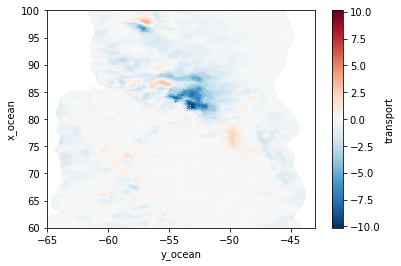

In [28]:
transport_new.plot()

In [29]:
vh_eddy_interp = transport_new.transpose('y_ocean','x_ocean')
save_dir = '/g/data/x77/cy8964/Post_Process/New_SO/'
ds = xr.Dataset({'vh_eddy_interp': vh_eddy_interp})
ds.to_netcdf(save_dir+'KP_vh_eddy_interp_circumpolar_up_arm.nc')
